In [1]:
import time
start_time = time.time()
def time_check(start=None):
    if start:
        t = time.time() - start
    else:
        t = time.time() - start_time
    print(f'Time check: {t//60:.0f} minutes and {t%60:.0f} seconds')

The dataset used in this notebook was compiled by me in several other notebooks. See the `compile_and_filter_dataset` folder in this repository for the detailed process of how the data was collected. Here is a summary of the work done to collect this data.

#### 1. Get movie discussions
Use the PRAW library, a wrapper for the Reddit API.
* Collect the URLs and titles for all available official movie discussions on Reddit's r/movies. This should be 1,000 rows. 
    * Filter out discussions not related to movies, such as discussions of award ceremonies and end-of-year threads.
    * Use RegEx to clean up movie titles. Strip words from the post's title like
        * "official discussion"
        * "spoilers"
        * "international release"
    *  Save resulting dataframe as `movies_cleaned.csv`.

#### 2. Get comments from movies
Using PRAW and the URLS collected in the last notebook:
* Get the top 100 comments from each discussion thread (some will have fewer than 100) as well as the date the thread was posted.
    * The date will be useful when trying to match the Reddit post with the movie's IMDb score.
    * Save comments and dates in a dictionary format with the discussion's Reddit ID as the key.
    * This dictionary should be read as a dataframe and transposed.
* Save the resulting dictionary as a JSON file `movies_comments.json`.

#### 3. Clean comments
Using the previously saved JSON file:
* Read it in as a dataframe.
* Combine the comments from movies that were discussed on Reddit twice. Some movies had an discussions for international releases and US releases. Choose one post and ID to act as the ID for this movie.
    * This requires some granular work, since some movies simply have the same title, etc.
* Save this dataframe as a CSV, excluding the comments, as `reddit_movies_final.csv`.
* Explode comments. Resulting dataframe should have tens of thousands of rows.
* Drop duplicate comments.
    * More granular work here. Not all duplicates should be dropped. Only ones that appear to be spam or administrative.
* Remove administrative comments from each discussion. They only show up in a few discussions, but they are usually the first comment and contain keywords like "r/movies", "pinned", or "FYI".
* Save the resulting dataframe as `comments_exploded.csv`.

#### 4. Merge movies with IMDb score
* Download IMDb datasets "title.basics.tsv.gz" and "title.ratings.tsv.gz" from https://www.imdb.com/interfaces/
* Read in the datasets as dataframes. Drop non-movies and merge them on the unique identifier.
* Merge this IMDb dataset with the Reddit movies dataset. Use movie title and release date as the features to merge on.
    * Filter out duplicates. A surprising number of blockbuster movies share a release year and title with other, lesser known movies.
        * This requires granular work and care. Some Reddit movies might match with the wrong IMDb movie. Some Reddit movies were discussed in the year after the movie was released.
    * Some movies in the Reddit dataframe need their titles changed to match the IMDb counterpart (misspelled).
* Merge the resulting dataset with the comments dataset.
* Save resulting data as `data_final.csv`.

In [2]:
import numpy as np
import pandas as pd
import warnings
import datetime

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from spacy import displacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import RootMeanSquaredError, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from transformers import pipelines

import re
from collections import OrderedDict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

import praw

import json

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
seed = 55
np.random.seed(seed)

## Data Preparation

### Read in final dataset, containing reddit comments and IMDb scores.

In [3]:
df = pd.read_csv('./data/data_final.csv')

In [4]:
df_only_movies = pd.read_csv('./data/reddit_movies_final.csv', index_col=0)

In [5]:
df.head()

,id,tconst,title,originalTitle,comments,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating
0,vzcwal,tt13406136,the princess,The Princess,Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on h...,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
1,vzcwal,tt13406136,the princess,The Princess,"Silly, but entertaining and non stop action",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
2,vzcwal,tt13406136,the princess,The Princess,"The yassification of The Raid\n\nActually, this was fun enough and mad respect to Joey King for ...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
3,vzcwal,tt13406136,the princess,The Princess,"Honestly, this was pretty fun. The plot is nothing special yes.\n\nBut Joey King was actually e...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
4,vzcwal,tt13406136,the princess,The Princess,"Man, I loved this movie. Yeah, it was campy, but whatever. The premise worked for me, I liked th...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6


Reducing the dataset to only *potentially* relevant features, although I may not use all.

In [6]:
df = df[[
    'id', 'tconst', 'title', 'averageRating', 'numVotes',
    'runtimeMinutes', 'genres', 'comments', 
    ]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              70692 non-null  object 
 1   tconst          70692 non-null  object 
 2   title           70692 non-null  object 
 3   averageRating   70692 non-null  float64
 4   numVotes        70692 non-null  int64  
 5   runtimeMinutes  70692 non-null  float64
 6   genres          70621 non-null  object 
 7   comments        70692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.3+ MB


In [8]:
df.isna().sum()

id                 0
tconst             0
title              0
averageRating      0
numVotes           0
runtimeMinutes     0
genres            71
comments           0
dtype: int64

The only feature with missing values is `genre`.

In [9]:
df[df['genres'].isna()]['title'].value_counts()

studio 666    71
Name: title, dtype: int64

They're all for the same movie, Studio 666. I'm not sure why this wasn't in the dataset, but on IMDb's website, this movie's genres are comedy, horror, music.

In [10]:
df.loc[:,'genres'][df.loc[:,'title'] == 'studio 666'] = "Comedy,Horror,Music"

### Visualizing the distribution of the target variable `averageRating`

In [11]:
################################################

In [12]:
ratings_df = df.drop_duplicates(subset='id')[['id', 'tconst', 'title', 'runtimeMinutes', 'genres', 'numVotes', 'averageRating']]

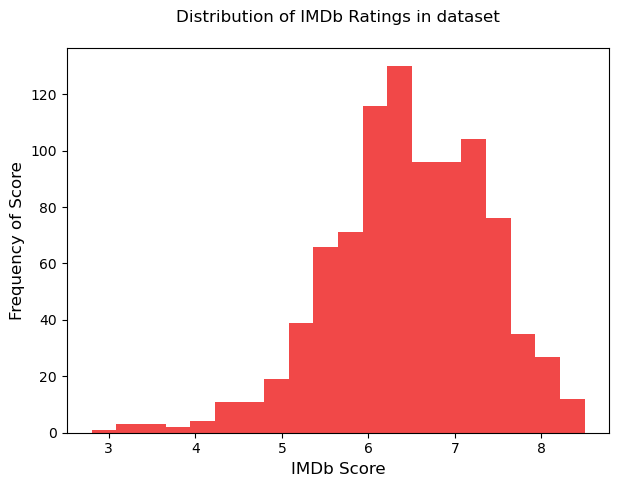

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ratings_df['averageRating'].hist(ax=ax, color='#f14848', bins=20, grid=False)
ax.set_title('Distribution of IMDb Ratings in dataset\n')
ax.set_xlabel('IMDb Score', size=12),
ax.set_ylabel('Frequency of Score', size=12)
fig.set_facecolor('white')

In [14]:
######################
# Visualize anything else here?
#######################

In [15]:
###################
# DISCUSS THIS DISTRUBUTION
###################

In [16]:
################################################

### Train-Test Split
**Currently, every row is its own comment.** This will be important when tokenizing comments, but in order for train-test split to work properly, I need each movie's comments to remain together.

In [17]:
movie_ids = df['id'].unique()

ids_train, ids_test = train_test_split(
    movie_ids, test_size=0.8, random_state=seed
)

ids_test, ids_val = train_test_split(
    ids_test, test_size=0.5, random_state=seed
)

df_train = df[df['id'].isin(ids_train)]
df_test = df[df['id'].isin(ids_test)]
df_val = df[df['id'].isin(ids_val)]

df_train: Used for training the model and extracting meta-data about comments

df_val: Used for selecting a model

df_test: Used to score the final model

In [18]:
#################################################

### Cleaning and tokenizing comments
**Each comment is currently its own row.** This will be important when cleaning and tokenizing comments, but later I'll have to combine each movie into its own row.

In [19]:
# Lowercase

df_train['comments'] = df_train['comments'].apply(lambda x: x.lower())

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\1573326677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(lambda x: x.lower())


In [20]:
# Replace URLs with "HYPERLINK"

df_train['comments'] = df_train['comments'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='HYPERLINK', string=x)
        )

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\4228460656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(


In [21]:
# Remove excessive white space and newlines

df_train['comments'] = df_train['comments'].apply(lambda x: x.replace("\n", " "))

df_train['comments'] = df_train['comments'].apply(
    lambda x: re.sub(
        pattern=r' {2,}', repl=' ', string=x)
        )

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\1573692214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(lambda x: x.replace("\n", " "))
C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\1573692214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(


In [22]:
# Ensuring apostrophes and quotation marks are consistent

df_train['comments'] = df_train['comments'].apply(lambda x: re.sub(r"’|‘", repl="'", string=x))
df_train['comments'] = df_train['comments'].apply(lambda x: re.sub(r"“|”", repl='"', string=x))

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\3320712550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(lambda x: re.sub(r"’|‘", repl="'", string=x))
C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\3320712550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments'] = df_train['comments'].apply(lambda x: re.sub(r"“|”", repl='"', string=x))


In [23]:
##########
# WHY NOT REMOVE PUNCTUATION?
##########

**Setting up a tokenizer with SpaCy**

In [24]:
# Disabling certain components to keep it light

nlp = spacy.load(
    "en_core_web_sm",
    disable=[
        "ner", "textcat", "custom",
        "entity_linker", "entity_linker",
        "textcat_multilabel", "transformer"
    ]
    )

In [25]:
def spacy_tokenizer(doc):
    return [t.text.lower() for t in doc]

In [26]:
# Making sure the tokenizer works

example_comment = df_train.loc[47825]['comments']
display(example_comment)
print(spacy_tokenizer(nlp(example_comment)))

'so is nobody going to mention how they were living in bruce wayne\'s house? "a rich eccentric billionaire who didn\'t like to be seen coming or going"'

['so', 'is', 'nobody', 'going', 'to', 'mention', 'how', 'they', 'were', 'living', 'in', 'bruce', 'wayne', "'s", 'house', '?', '"', 'a', 'rich', 'eccentric', 'billionaire', 'who', 'did', "n't", 'like', 'to', 'be', 'seen', 'coming', 'or', 'going', '"']


The tokenizer appears to work. It treats most punctuation as tokens, so I will likely add punctuation to my stop word list.

#### Tokinizing

In [27]:
# Turning each comment into document in SpaCy format 
# *** This cell usually takes about 2-3 minutes to run ***

df_train['comments_spacy'] = df_train['comments'].apply(nlp)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\2008664100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['comments_spacy'] = df_train['comments'].apply(nlp)


In [28]:
df_train['tokens'] = df_train['comments_spacy'].apply(spacy_tokenizer)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\407130812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tokens'] = df_train['comments_spacy'].apply(spacy_tokenizer)


In [29]:
time_check()

Time check: 2 minutes and 46 seconds


**Stop words**

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [30]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = [p for p in string.punctuation]
stopword_list = list(set(sw_spacy + sw_nltk + punct))

In [31]:
len(stopword_list)

414

Are there any other other words I should include in stop words?

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\82895983.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


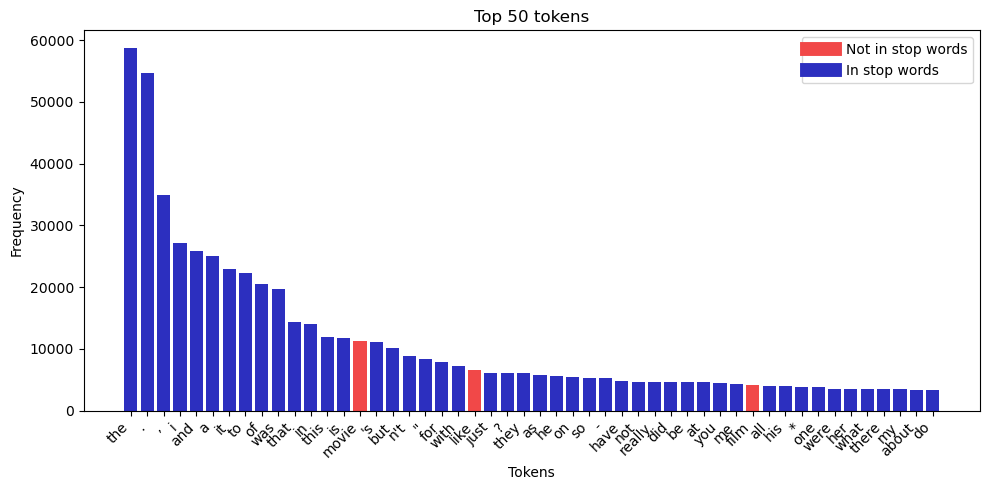

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(df_train['tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
extra_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in extra_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title('Top 50 tokens')
custom_bars = [Line2D([0], [0], color='#f14848', lw=10), Line2D([0], [0], color='#2c2fbf', lw=10)]
ax.legend(custom_bars, ['Not in stop words', 'In stop words'], fontsize=10)
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_50_tokens', dpi=500)
plt.show()

The tokens **movie**, **like**, and **film** occur as frequently as many stop words. I'll add them to the stop word list. These words get thrown around so often in r/movies that they probably don't contribute much value in an ML context.

In [33]:
stopword_list.extend(["movie", "like", "film"])

#### Making tokens without stop words:

In [34]:
df_train['tokens_no_sw'] = df_train['tokens'].apply(
    lambda x: [t for t in x if t not in stopword_list]
)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\533525562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tokens_no_sw'] = df_train['tokens'].apply(


Seeing most frequent tokens without stopwords:

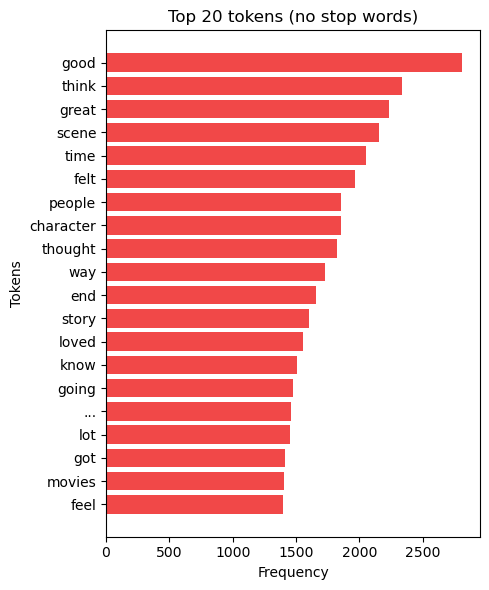

In [35]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_tok = OrderedDict(
    FreqDist(df_train['tokens_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_tok.keys())[::-1]
freq = list(top_20_tok.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Tokens', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 tokens (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_tokens_no_sw', dpi=500)
plt.show()

Interesting that commenters used elipses ("...") often enough that it's in the top 20 tokens.

Previewing the restulting features:

In [36]:
df_train.sample(5)

,id,tconst,title,averageRating,numVotes,runtimeMinutes,genres,comments,comments_spacy,tokens,tokens_no_sw
6330,r7oq0f,tt6823148,benedetta,6.7,18554,131.0,"Biography,Drama,History","""heard joke once: man goes to nuncio. says he's got the plague. says life seems harsh and cruel....","("", heard, joke, once, :, man, goes, to, nuncio, ., says, he, 's, got, the, plague, ., says, lif...","["", heard, joke, once, :, man, goes, to, nuncio, ., says, he, 's, got, the, plague, ., says, lif...","[heard, joke, man, goes, nuncio, says, got, plague, says, life, harsh, cruel, says, feels, pain,..."
54021,7dhu3f,tt0974015,justice league,6.1,449148,120.0,"Action,Adventure,Fantasy",the flash's wide-eyed terror as he realized that superman could see him.,"(the, flash, 's, wide, -, eyed, terror, as, he, realized, that, superman, could, see, him, .)","[the, flash, 's, wide, -, eyed, terror, as, he, realized, that, superman, could, see, him, .]","[flash, wide, eyed, terror, realized, superman]"
17624,kkbeha,tt9620292,promising young woman,7.5,168620,113.0,"Crime,Drama,Mystery",the first scene with adam brody really set the tone of the movie for me. him at the bar with his...,"(the, first, scene, with, adam, brody, really, set, the, tone, of, the, movie, for, me, ., him, ...","[the, first, scene, with, adam, brody, really, set, the, tone, of, the, movie, for, me, ., him, ...","[scene, adam, brody, set, tone, bar, colleagues, talks, unfortunate, business, meeting, held, go..."
54210,7c5s8i,tt5649144,the florida project,7.6,113978,111.0,Drama,"finally saw it last night. the theater was pretty empty, maybe 5 or 6 total people. loved how be...","(finally, saw, it, last, night, ., the, theater, was, pretty, empty, ,, maybe, 5, or, 6, total, ...","[finally, saw, it, last, night, ., the, theater, was, pretty, empty, ,, maybe, 5, or, 6, total, ...","[finally, saw, night, theater, pretty, maybe, 5, 6, total, people, loved, beautiful, shot, felt,..."
10237,p8fjiu,tt10731768,sweet girl,5.5,31812,110.0,"Action,Drama,Thriller",ok but is everyone going to ignore the the fact that she was like what a 16 self trained ninja a...,"(ok, but, is, everyone, going, to, ignore, the, the, fact, that, she, was, like, what, a, 16, se...","[ok, but, is, everyone, going, to, ignore, the, the, fact, that, she, was, like, what, a, 16, se...","[ok, going, ignore, fact, 16, self, trained, ninja, 2, years, living, parents, died, jumps, 100,..."


### Further breaking down tokens
#### Lemmatization

In [37]:
###############
# WHAT IS IT
##############

In [38]:
def spacy_lemmatizer(doc):
    return [t.lemma_.lower() for t in doc]

In [39]:
df_train['lemmas'] = \
    df_train['comments_spacy'].apply(spacy_lemmatizer)

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\1621206567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lemmas'] = \


In [40]:
FreqDist(df_train['lemmas'].explode()).most_common(20)

[('the', 58650),
 ('be', 56314),
 ('.', 54680),
 (',', 34965),
 ('i', 31494),
 ('and', 25925),
 ('a', 25023),
 ('it', 22955),
 ('to', 22703),
 ('of', 20437),
 ('that', 14346),
 ('in', 14003),
 ('not', 13899),
 ('movie', 12722),
 ('this', 11964),
 ('do', 10595),
 ('have', 10227),
 ('but', 10076),
 ('"', 8316),
 ('for', 7894)]

#### Lemmatized stop words
In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [41]:
stopword_list_lem = []

sw_lem_Series = \
    df_train['comments_spacy'].apply(
        lambda x: [t.lemma_.lower() for t in x if t.text in stopword_list]
        )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [42]:
# Lemmatized tokens, excluding stop words

df_train['lemmas_no_sw'] = df_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22660\611311935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lemmas_no_sw'] = df_train['lemmas'].apply(


Seeing most frequent tokens without stopwords:

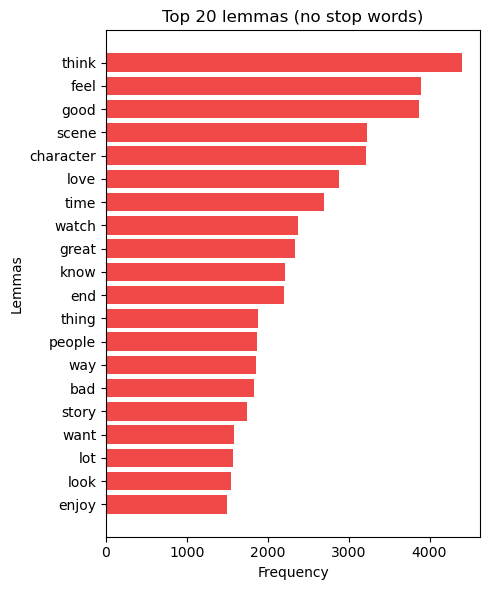

In [43]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_lem = OrderedDict(
    FreqDist(df_train['lemmas_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_lem.keys())[::-1]
freq = list(top_20_lem.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Lemmas', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 lemmas (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_lemmas_no_sw', dpi=500)
plt.show()

### More linguistic feature engineering
I will use the SpaCy library to extract more linguistic features from the tweets.

### Vectorized part of speech (POS) tags
The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part of speech.

Here are some examples of what the tool can identify

In [44]:
pos_samples = df_train.loc[[46700, 24127, 53173]]

options_displacy_pos = {'compact':True, 'distance':90, 'bg':'#3056ff', 'color':'fff'}

# displacy.render((pos_samples['comments_spacy'].loc[46700]), style='dep', jupyter=True, options=options_displacy_pos)

for idx in pos_samples.index:
    print(pos_samples['comments'].loc[idx])
    displacy.render((pos_samples['comments_spacy'].loc[idx]), style='dep', jupyter=True, options=options_displacy_pos)  

colin firth looked like he was having the time of his life. i know he said the first one was the most fun he had in a movie so i'm not surprised. loved this movie though. i wanna watch it over and over again like the first one! 


ben affleck is good at acting. was great in boiler room, good will hunting, the town. i enjoyed this movie very much


went in expecting a movie like the prestige. i had no idea it was going to be a musical. what a shocker. i liked it. surprisingly. it was good!


I plan to use this SpaCy tool in order to vectorize the universal [parts of speech](https://universaldependencies.org/u/pos/all.html) of each tweet.

First, I'll convert each token into a string of its POS tag.

In [45]:
# Spacy POS

def spacy_pos(doc):
    return [t.pos_ for t in doc]

# Testing the function on a sample
df_train['comments_spacy'].sample(5, random_state=seed).apply(spacy_pos)

6330     [PUNCT, VERB, NOUN, ADV, PUNCT, NOUN, VERB, ADP, PROPN, PUNCT, VERB, PRON, AUX, VERB, DET, NOUN,...
54021        [DET, NOUN, PART, ADJ, PUNCT, ADJ, NOUN, SCONJ, PRON, VERB, PRON, NOUN, AUX, VERB, PRON, PUNCT]
17624    [DET, ADJ, NOUN, ADP, PROPN, PROPN, ADV, VERB, DET, NOUN, ADP, DET, NOUN, ADP, PRON, PUNCT, PRON...
54210    [ADV, VERB, PRON, ADJ, NOUN, PUNCT, DET, NOUN, AUX, ADV, ADJ, PUNCT, ADV, NUM, CCONJ, NUM, ADJ, ...
10237    [INTJ, CCONJ, AUX, PRON, VERB, PART, VERB, DET, DET, NOUN, SCONJ, PRON, AUX, ADP, PRON, DET, NUM...
Name: comments_spacy, dtype: object

In [46]:
time_check()

Time check: 3 minutes and 9 seconds


In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [47]:
# Making dataframes of vectorized POS tags

pos_vectorizer = CountVectorizer(tokenizer=spacy_pos, lowercase=False)
pos_vec_train = pos_vectorizer.fit_transform(df_train['comments_spacy'])
pos_vec_df_train = pd.DataFrame(
        pos_vec_train.toarray(),
        columns=pos_vectorizer.get_feature_names_out(),
        index=df_train.index
)

In [48]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
121,2,0,3,1,0,1,0,1,0,0,3,0,2,0,0,0,3,0
122,9,7,6,4,2,6,0,8,0,2,10,0,6,0,0,0,6,0
123,2,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0
124,4,5,3,2,1,4,0,6,0,0,2,1,5,0,0,0,2,0
125,0,1,1,1,0,1,0,2,1,1,0,0,1,0,0,0,1,0


In [49]:
# QUESTIONS:
# WHEN is a good time to aggregate the rows back into movies? After created lemmas_no_sw?
# Can you even do TF-IDF on the aggregated rows? 
# HOW to aggregate POS tags and meta-features? Should I just leave that out??? 
# -- Probably just join the original comments with a ". "

# NEXT
####################
# Pick POS tags with strongest correlation with IMDb...
# Sentiment analysis????
# Meta feature engineering 
# You can plot meta-features against imdb score
#######################
# Apply everything to test and val
# Modeling

In [ ]:
################

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)], 
    stop_words=stopword_list_stem,
    max_features=1000
    )

X_train_vec = tfidf.fit_transform(X_train['comments'])

X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_train.index
    )
X_train_vec_df.head()


In [ ]:
scaler = StandardScaler()
X_train_vec_df_scaled = scaler.fit_transform(X_train_vec_df)
X_train_vec_df_scaled = pd.DataFrame(X_train_vec_df_scaled, index=X_train.index, columns=X_train_vec_df.columns)

X_train_vec_df_scaled.head()

In [ ]:
X_test_vec = tfidf.transform(X_test['comments'])

X_test_vec_df = pd.DataFrame(
    X_test_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_test.index
    )

X_test_vec_df_scaled = scaler.transform(X_test_vec_df)
X_test_vec_df_scaled = pd.DataFrame(X_test_vec_df_scaled, index=X_test.index, columns=X_test_vec_df.columns)

In [ ]:
X_val_vec = tfidf.transform(X_val['comments'])

X_val_vec_df = pd.DataFrame(
    X_val_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_val.index
    )

X_val_vec_df_scaled = scaler.transform(X_val_vec_df)
X_val_vec_df_scaled = pd.DataFrame(X_val_vec_df_scaled, index=X_val.index, columns=X_val_vec_df.columns)

In [ ]:
n_input = X_train_vec_df_scaled.shape[1]
n_input

In [ ]:
set_seed(seed)

model_baseline = models.Sequential()

model_baseline.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_baseline.add(layer=layers.Dense(
    units=500,
    activation='relu',
    input_shape=(n_input,),
    kernel_regularizer=regularizers.L2(.25)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=400,
    activation='relu',
    kernel_regularizer=regularizers.L2(.25)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=300,
    activation='relu',
    kernel_regularizer=regularizers.L2(.25)
    ))

# model_baseline.add(layers.Dropout(0.2))

# model_baseline.add(layer=layers.Dense(
#     units=250,
#     activation='relu',
#     kernel_regularizer=regularizers.L2(.25)
#     ))

model_baseline.add(layer=layers.Dense(
    units=1,
    ))

model_baseline.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[RootMeanSquaredError()]
    )

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=10)
    ]

model_hist_baseline = model_baseline.fit(
    np.array(X_train_vec_df_scaled),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_vec_df_scaled, y_val),
    verbose=True,
    callbacks=early_stopping
)

In [ ]:
def plot_nn_curves(model_history):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(['loss', 'root_mean_squared_error']):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

plot_nn_curves(model_hist_baseline)


In [ ]:
r2_score(y_val, model_baseline.predict(X_val_vec_df_scaled))

In [ ]:
#########################################